# MS041 Preprocess
Created: 02/09/2024 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS041'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/raw/MS041_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2582015  =      0.000 ...  2521.499 secs...


In [7]:
mne_data

<RawEDF | MS041_SWB.edf, 276 x 2582016 (2521.5 s), ~5.31 GB, data loaded>

In [8]:
mne_data.ch_names

['LalS1',
 'LalS2',
 'LalS3',
 'LalS4',
 'LalS5',
 'LalS6',
 'LalS7',
 'LalS8',
 'LalS9',
 'LalS10',
 'LalS11',
 'LalS12',
 'LalS13',
 'LalS14',
 'LalS15',
 'LalS16',
 'RalS1',
 'RalS2',
 'RalS3',
 'RalS4',
 'RalS5',
 'RalS6',
 'RalS7',
 'RalS8',
 'RalS9',
 'RalS10',
 'RalS11',
 'RalS12',
 'RalS13',
 'RalS14',
 'RalS15',
 'RalS16',
 'LCM1',
 'LCM2',
 'LCM3',
 'LCM4',
 'LCM5',
 'LCM6',
 'LCM7',
 'LCM8',
 'LCM9',
 'LCM10',
 'LCM11',
 'LCM12',
 'LCM13',
 'LCM14',
 'LCM15',
 'LCM16',
 'RCM1',
 'RCM2',
 'RCM3',
 'RCM4',
 'RCM5',
 'RCM6',
 'RCM7',
 'RCM8',
 'RCM9',
 'RCM10',
 'RCM11',
 'RCM12',
 'RCM13',
 'RCM14',
 'RCM15',
 'RCM16',
 'LHsch1',
 'LHsch2',
 'LHsch3',
 'LHsch4',
 'LHsch5',
 'LHsch6',
 'LHsch7',
 'LHsch8',
 'RHscl1',
 'RHscl2',
 'RHscl3',
 'RHscl4',
 'RHscl5',
 'RHscl6',
 'LPVNH1',
 'LPVNH2',
 'LPVNH3',
 'LPVNH4',
 'LPVNH5',
 'LPVNH6',
 'LPVNH7',
 'LPVNH8',
 'LPVNH9',
 'LPVNH10',
 'RaPVNH1',
 'RaPVNH2',
 'RaPVNH3',
 'RaPVNH4',
 'RaPVNH5',
 'RaPVNH6',
 'RaPVNH7',
 'RaPVNH8',
 'C

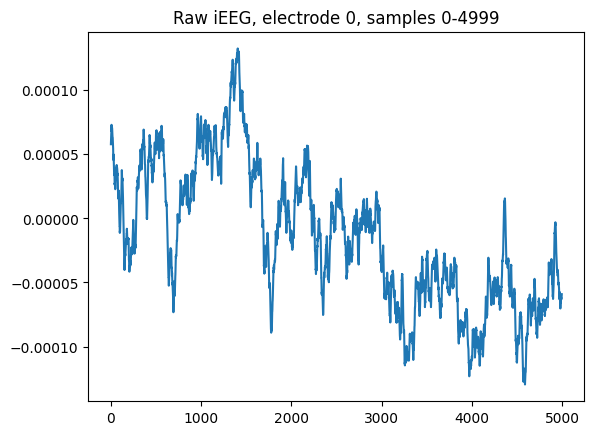

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [9]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   47.2s finished


<RawEDF | MS041_SWB.edf, 276 x 1260750 (2521.5 s), ~2.59 GB, data loaded>

### Photodiode
- examine photodiode 

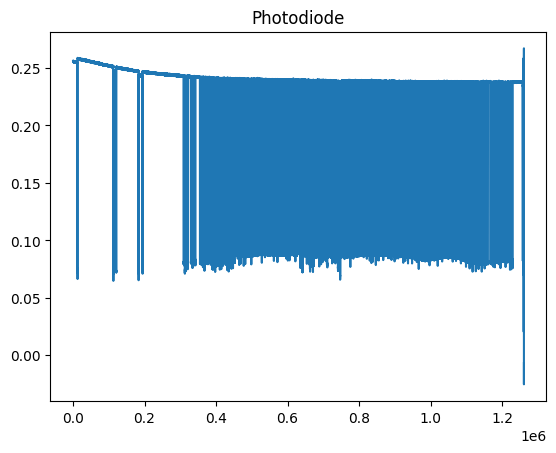

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [11]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/photodiode.fif
[done]


In [12]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS041_SWB.edf, 275 x 1260750 (2521.5 s), ~2.58 GB, data loaded>

### Notch filter line noise

In [13]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:   12.4s finished


<RawEDF | MS041_SWB.edf, 275 x 1260750 (2521.5 s), ~2.58 GB, data loaded>

### Anatomical Localization

In [14]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS041_SWB.edf, 275 x 1260750 (2521.5 s), ~2.58 GB, data loaded>

In [15]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-2.951279,45.198909,-7.791763,-3.272108,34.300703,-7.591226,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCaS10,Unknown,-9.741577,49.198813,36.561299,-10.894925,36.642095,40.425046,White,Left Cerebral White Matter,Unknown,L Superior Frontal Gyrus,Unknown,Unknown,WM,NaN
2,LaCaS11,A9l_L,-10.141006,49.998793,42.155379,-11.168208,37.254152,46.536518,White,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 3 C,WM,NaN
3,LaCaS12,A9l_L,-10.939865,50.398784,46.550728,-11.996877,37.506127,51.340672,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 3 C,NaN,NaN
4,LaCaS13,A9l_L,-11.339294,50.798774,51.745231,-12.468773,37.749497,57.048356,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 4 C,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,RpPVNH5,IFJ_R,31.799072,18.799544,41.356225,33.151609,7.569747,43.261551,White,Right MFG middle frontal gyrus,Unknown,Unknown,R MFG,Unknown,WM,NaN
220,RpPVNH6,IFJ_R,34.595078,18.399553,44.952419,36.052074,7.273119,47.267464,White,Right MFG middle frontal gyrus,Unknown,R Middle Frontal Gyrus,R MFG,Right middle frontal gyrus 7 B,WM,NaN
221,RpPVNH7,IFJ_R,37.391083,18.399553,48.948191,38.956678,7.438600,51.773552,Gray,Right MFG middle frontal gyrus,Unknown,R Middle Frontal Gyrus,R MFG,Right middle frontal gyrus 7 B,NaN,NaN
222,RpPVNH8,A6vl_R,40.187088,18.799544,52.544385,41.818453,8.047926,55.881570,Gray,Right MFG middle frontal gyrus,Unknown,R Middle Frontal Gyrus,R MFG,Right middle frontal gyrus 7 B,NaN,NaN


In [16]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT10',
 'LAglT11',
 'LAglT12',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LaIS1',
 'LaIS10',
 'LaIS11',
 'LaIS12',
 'LaIS13',
 'LaIS14',
 'LaIS15',
 'LaIS16',
 'LaIS2',
 'LaIS3',
 'LaIS4',
 'LaIS5',
 'LaIS6',
 'LaIS7',
 'LaIS8',
 'LaIS9',
 'LCM1',
 'LCM10',
 'LCM11',
 'LCM12',
 'LCM13',
 'LCM14',
 'LCM15',
 'LCM16',
 'LCM2',
 'LCM3',
 'LCM4',
 'LCM5',
 'LCM6',
 'LCM7',
 'LCM8',
 'LCM9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHsch1',
 'LHsch2',
 'LHsch3',
 'LHsch4',
 'LHsch5',
 'LHsch6',
 'LHsch7',
 'LHsch8',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LmOlF

In [17]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lals1', 'lals2', 'lals3', 'lals4', 'lals5', 'lals6', 'lals7', 'lals8', 'lals9', 'lals10', 'lals11', 'lals12', 'lals13', 'lals14', 'lals15', 'lals16', 'rals1', 'rals2', 'rals3', 'rals4', 'rals5', 'rals6', 'rals7', 'rals8', 'rals9', 'rals10', 'rals11', 'rals12', 'rals13', 'rals14', 'rals15', 'rals16', 'c97', 'c98', 'abs1', 'abs2', 'chest1', 'chest2', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c254', 'c255', 'c256', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [18]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [19]:
unmatched_seeg #make sure there are no unmatched names


[]

In [20]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [21]:
new_name_dict #make sure this passes the eye test 


{'lals1': 'lais1',
 'lals2': 'lais2',
 'lals3': 'lais3',
 'lals4': 'lais4',
 'lals5': 'lais5',
 'lals6': 'lais6',
 'lals7': 'lais7',
 'lals8': 'lais8',
 'lals9': 'lais9',
 'lals10': 'lais10',
 'lals11': 'lais11',
 'lals12': 'lais12',
 'lals13': 'lais13',
 'lals14': 'lais14',
 'lals15': 'lais15',
 'lals16': 'lais16',
 'rals1': 'rais1',
 'rals2': 'rais2',
 'rals3': 'rais3',
 'rals4': 'rais4',
 'rals5': 'rais5',
 'rals6': 'rais6',
 'rals7': 'rais7',
 'rals8': 'rais8',
 'rals9': 'rais9',
 'rals10': 'rais10',
 'rals11': 'rais11',
 'rals12': 'rais12',
 'rals13': 'rais13',
 'rals14': 'rais14',
 'rals15': 'rais15',
 'rals16': 'rais16',
 'lcm1': 'lcm1',
 'lcm2': 'lcm2',
 'lcm3': 'lcm3',
 'lcm4': 'lcm4',
 'lcm5': 'lcm5',
 'lcm6': 'lcm6',
 'lcm7': 'lcm7',
 'lcm8': 'lcm8',
 'lcm9': 'lcm9',
 'lcm10': 'lcm10',
 'lcm11': 'lcm11',
 'lcm12': 'lcm12',
 'lcm13': 'lcm13',
 'lcm14': 'lcm14',
 'lcm15': 'lcm15',
 'lcm16': 'lcm16',
 'rcm1': 'rcm1',
 'rcm2': 'rcm2',
 'rcm3': 'rcm3',
 'rcm4': 'rcm4',
 'rcm5': '

In [22]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS041_SWB.edf, 275 x 1260750 (2521.5 s), ~2.58 GB, data loaded>

In [23]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 110 left sEEG and 114 right sEEG electrodes
We have a total of 224 sEEG electrodes


In [24]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS041_SWB.edf, 275 x 1260750 (2521.5 s), ~2.58 GB, data loaded>

In [25]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS041_SWB.edf, 224 x 1260750 (2521.5 s), ~2.10 GB, data loaded>

In [26]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS041_SWB.edf, 224 x 1260750 (2521.5 s), ~2.10 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 14,
 'laglt': 12,
 'lais': 16,
 'lcm': 16,
 'lhplt': 12,
 'lhsch': 8,
 'lmcms': 10,
 'lmolf': 12,
 'lpvnh': 10,
 'racas': 14,
 'raglt': 12,
 'rais': 16,
 'rapvnh': 8,
 'rcm': 16,
 'rhplt': 12,
 'rhscl': 6,
 'rmcms': 8,
 'rmolf': 12,
 'rppvnh': 10}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [31]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lhplt6',
 'lhplt8',
 'racas10',
 'raglt2',
 'raglt3',
 'rcm16',
 'rhplt10',
 'rhplt3',
 'rppvnh7',
 'rppvnh8']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


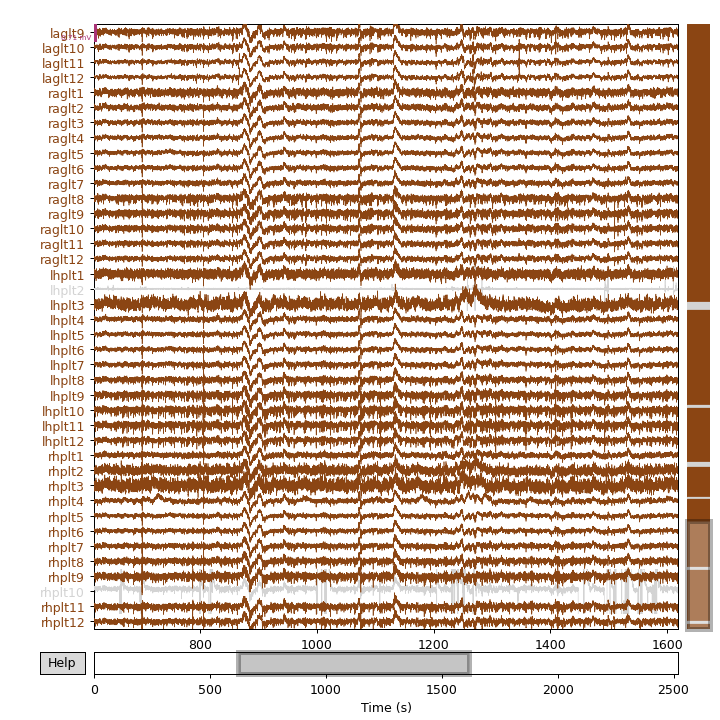

In [32]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/30)


In [27]:
mne_data.info['bads'] = ['rppvnh8',
 'rppvnh9',
 'rppvnh10',
 'lmcms8',
 'lmolf12',
 'lmolf11',
 'rmolf12',
 'rhplt10',
 'lhplt2']

In [28]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 9 items (rppvnh8, rppvnh9, rppvnh10, lmcms8, lmolf12, lmolf11, ...)
 ch_names: lais1, lais2, lais3, lais4, lais5, lais6, lais7, lais8, lais9, ...
 chs: 224 sEEG
 custom_ref_applied: False
 dig: 224 items (224 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 12:35:44 UTC
 nchan: 224
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [29]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [30]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=103, n_times=1260750
    Range : 0 ... 1260749 =      0.000 ...  2521.498 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas11-lacas12, lacas12-lacas13, laglt1-laglt2, laglt2-laglt3, laglt3-laglt4, laglt4-laglt5, laglt8-laglt9, laglt9-laglt10, lais1-lais2, lais2-lais3, lais3-lais4, lais4-lais5, lais5-lais6, lais6-lais7, lais11-lais12, lais12-lais13, lais13-lais14, lais14-lais15, lcm1-lcm2, lcm2-lcm3, lcm3-lcm4, lcm4-lcm5, lcm13-lcm14, lhplt1-lhplt3, lhplt3-lhplt4, lhplt4-lhplt5, lhplt5-lhplt6, lhplt10-lhplt11, lhsch1-lhsch2, lhsch4-lhsch5, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmolf1-lmolf2, lmolf2-lmolf3, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lmolf8-lmolf9, lmolf9-lmolf10, lpvnh1-lpvnh2, lpvnh5-lpvnh6, lpvnh6-lpvnh7, lpvnh7-lpvnh8, racas9-ra

In [31]:
mne_data_bp_reref

<RawEDF | MS041_SWB.edf, 103 x 1260750 (2521.5 s), ~990.9 MB, data loaded>

In [32]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lacas11-lacas12',
 'lacas12-lacas13',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt4-laglt5',
 'laglt8-laglt9',
 'laglt9-laglt10',
 'lais1-lais2',
 'lais2-lais3',
 'lais3-lais4',
 'lais4-lais5',
 'lais5-lais6',
 'lais6-lais7',
 'lais11-lais12',
 'lais12-lais13',
 'lais13-lais14',
 'lais14-lais15',
 'lcm1-lcm2',
 'lcm2-lcm3',
 'lcm3-lcm4',
 'lcm4-lcm5',
 'lcm13-lcm14',
 'lhplt1-lhplt3',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt5-lhplt6',
 'lhplt10-lhplt11',
 'lhsch1-lhsch2',
 'lhsch4-lhsch5',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmolf1-lmolf2',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'lmolf9-lmolf10',
 'lpvnh1-lpvnh2',
 'lpvnh5-lpvnh6',
 'lpvnh6-lpvnh7',
 'lpvnh7-lpvnh8',
 'racas9-racas10',
 'racas10-racas11',
 'racas11-racas12',
 'racas12

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


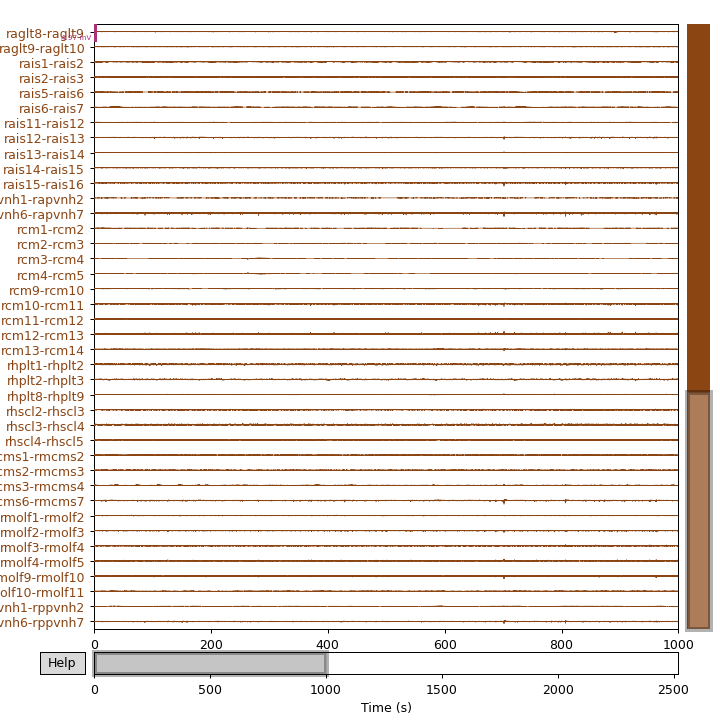

In [39]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


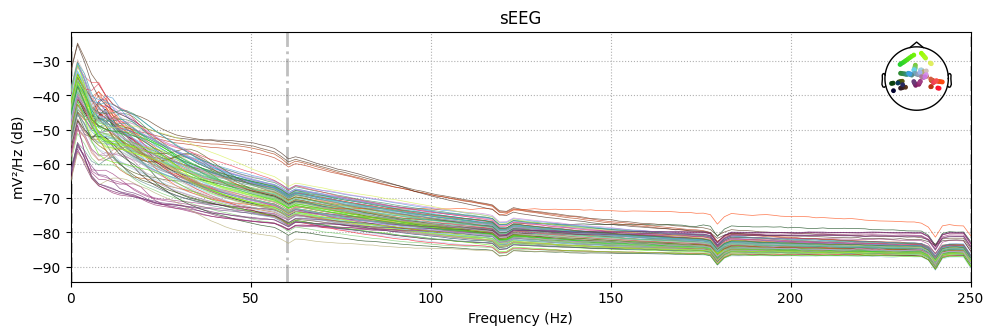

In [33]:
mne_data_bp_reref.compute_psd().plot()

In [34]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/bp_ref_ieeg.fif
[done]


## Save mne_data

In [35]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [36]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [37]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/photodiode.fif...
Isotrak not found
    Range : 0 ... 1260749 =      0.000 ...  2521.498 secs
Ready.
Reading 0 ... 1260749  =      0.000 ...  2521.498 secs...


In [38]:
photodiode_data

<Raw | photodiode.fif, 1 x 1260750 (2521.5 s), ~9.6 MB, data loaded>

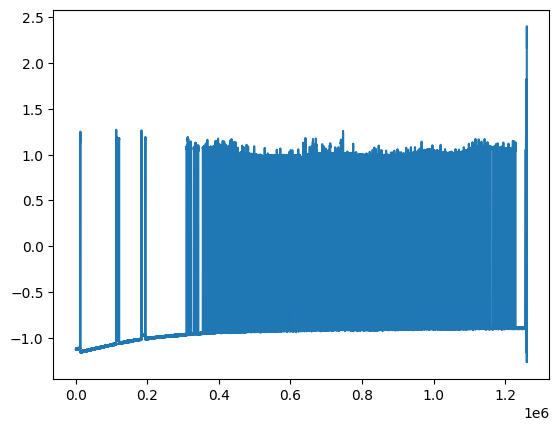

In [41]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.show()

In [143]:
temp_diode = photodiode_data.copy()
temp_data = -temp_diode._data[0,:]
# temp_data[0:200000] = np.min(temp_data)
# temp_data[1250000:] = np.min(temp_data)
temp_diode._data = temp_data

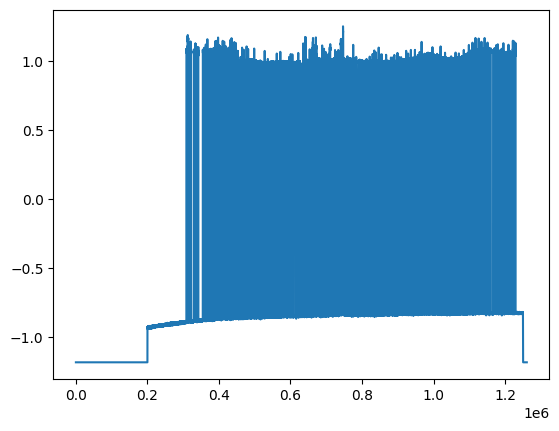

In [79]:
plt.plot(scipy.stats.zscore(temp_diode._data[:]))
plt.show()

In [147]:
### Photodiode alignment
smoothSize=15
windSize=11
height=0.75


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

15 blocks
...............

found matches for 143 of 166 pulses
10 blocks
..........

found matches for 144 of 166 pulses
7 blocks
.......

found matches for 105 of 166 pulses


In [148]:
print(slope, offset,smoothSize,windSize,height)

1.0000000925280892 389.6625837877916 15 11 0.75


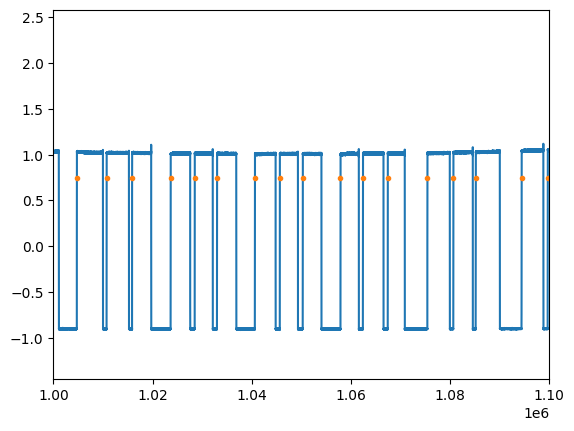

In [151]:
pulses = [(x*slope + offset) for x in beh_ts]
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses) * photodiode_data.info['sfreq'])-0.25,'.')

plt.xlim([1000000,1100000])
# plt.ylim([5,6])
plt.show()


## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [152]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [153]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [154]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [155]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/bp_ref_ieeg.fif...
    Range : 0 ... 1260749 =      0.000 ...  2521.498 secs
Ready.
Reading 0 ... 1260749  =      0.000 ...  2521.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    5.5s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 103 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS041/bp_ref_ieeg.fif...
    Range : 0 ... 1260749 =      0.000 ...  2521.498 secs
Ready.
Reading 0 ... 1260749  =      0.000 ...  2521.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    5.9s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 103 columns


In [156]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~177.1 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~412.9 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [157]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']


In [158]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 125 columns
Replacing existing metadata with 125 columns


In [159]:
epochs_all_evs[event].metadata

,lacas1-lacas2,lacas2-lacas3,lacas3-lacas4,lacas4-lacas5,lacas6-lacas7,lacas7-lacas8,lacas8-lacas9,lacas11-lacas12,lacas12-lacas13,laglt1-laglt2,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.52,1.92,0.00,0.00,2.52,1.92,0.00,0.60,1.26,0.00
1,NaN,NaN,NaN,[722.856],NaN,NaN,NaN,NaN,NaN,NaN,...,0.60,0.60,0.00,0.00,0.60,0.60,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,0.20,0.00,0.00,0.20,0.20,-0.40,-0.40,0.00,0.00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.12,-0.40,-1.12,-0.40,0.00,0.00,1.12,0.40,0.00,-0.56
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.72,0.52,0.00,0.00,0.72,0.52,0.00,0.20,0.36,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,noise,NaN,NaN,NaN,NaN,NaN,noise,NaN,NaN,...,-1.50,-0.30,-1.50,-0.30,0.00,0.00,1.50,0.30,0.00,-0.75
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,...,-1.44,-1.04,-1.44,-1.04,0.00,0.00,0.00,-0.40,0.00,-0.72
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.15,-0.15,-0.15,-0.15,0.00,0.00,0.15,0.15,0.00,0.00
148,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.26,0.40,0.00,0.00,1.26,0.40,-1.26,-0.40,0.63,0.00


### Save raw epoched data 

In [160]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [161]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [162]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [163]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [164]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [165]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 103, ~1.73 GB>}

In [166]:
power_epochs = {}

In [167]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
Adding metadata with 125 columns


In [168]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 103, ~8.64 GB>

In [169]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [170]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04082024


In [171]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


389.6625837877916
